# World Models

### 1. V-Model

### 2. M-Model

### 3. C-Model



In [20]:
import gym
from gym.spaces import Box
import numpy as np

try:
    import cv2
except ImportError:
    cv2 = None

In [21]:
env = gym.make("CarRacing-v0")

In [3]:
state = env.reset()

Track generation: 1105..1391 -> 286-tiles track


In [5]:
import matplotlib.pyplot as plt

[]

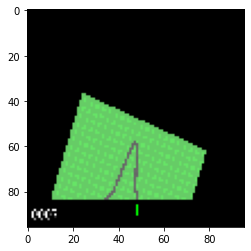

In [7]:
plt.imshow(state)
plt.plot()

In [8]:
state.shape

(96, 96, 3)

In [39]:
# bring observation in desired shape and scale observation between 0 and 1
class ObservationWrapper(gym.Wrapper):
    def __init__(self, env, image_size=(64,64,3), scale_obs=True):
        super().__init__(env)
        self.shape = image_size
        self.screen_size = image_size[0]
        self.scale_obs = scale_obs
        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        self.observation_space = Box(low=_low, high=_high, shape=image_size, dtype=_obs_dtype)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self._get_obs(state), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self._get_obs(obs)
        
    
    def _get_obs(self, obs):
        obs = cv2.resize(obs, (self.screen_size, self.screen_size), interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        return obs
    
class PytorchWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = torch.from_numpy(obs).reshape((3,64,64))
        return obs, reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        obs = torch.from_numpy(obs).reshape((3,64,64))
        return obs
        
        

In [40]:
env = ObservationWrapper(env, image_size=(64,64,3), scale_obs=True)
env = PytorchWrapper(env)

In [41]:
state = env.reset()

Track generation: 1064..1337 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1113..1405 -> 292-tiles track


array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.22352941, 0.22352941, 0.22352941],
        [0.2784314 , 0

In [70]:
import torch
import torch.nn as nn
from torch.distributions import Normal

In [121]:
class VAE():
    def __init__(self,):
        
        pass
        
class Encoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.output_mu = nn.Linear(1024, latent_size_N)
        self.output_sig = nn.Linear(1024, latent_size_N)
        self.softplus = nn.Softplus()
        
        
        
    
    def forward(self, img):
        
        x = torch.relu(self.conv1(img))
        print(x.shape)
        x = torch.relu(self.conv2(x))
        print(x.shape)
        x = torch.relu(self.conv3(x))
        print(x.shape)
        x = torch.relu(self.conv4(x))
        print(x.shape)
        
        mu = torch.tanh(self.output_mu(x.flatten(1)))
        sig = self.softplus(self.output_sig(x.flatten(1)))
        
        dist = Normal(mu, sig)
        
        latent_vector_z = dist.sample()
        
        return latent_vector_z

        
class Decoder(nn.Module):
    def __init__(self, state_size, latent_size_N=32):
        super(Decoder, self).__init__()
        
        self.in_linear = nn.Linear(32, 1024)
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2)
        
    def forward(self, latent_vector):
        
        x = torch.relu(self.in_linear(latent_vector)).unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.deconv1(x))
        print(x.shape)
        x = torch.relu(self.deconv2(x))
        print(x.shape)
        x = torch.relu(self.deconv3(x))
        print(x.shape)
        x = torch.sigmoid(self.deconv4(x))
        print(x.shape)
        return x

In [122]:
encoder = Encoder((64,64,3))
decoder = Decoder((64,64,3))

In [123]:
out = encoder(state.unsqueeze(0))

torch.Size([1, 32, 31, 31])
torch.Size([1, 64, 14, 14])
torch.Size([1, 128, 6, 6])
torch.Size([1, 256, 2, 2])


In [124]:
out.shape

torch.Size([1, 32])

In [125]:
decoder(out)

torch.Size([1, 128, 5, 5])
torch.Size([1, 64, 13, 13])
torch.Size([1, 32, 30, 30])
torch.Size([1, 3, 64, 64])


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<ReluBackward0>)